# 10.2a: Run 1001 Black Hole Population Time Series

**Track unique vector count across all 100,001 steps**

## The Question

We know from previous analysis:
- Step 0: 128 tokens → 1 unique vector (primordial singularity)
- Step 100: ~77 tokens escape → 77 unique vectors, 51 remain in black hole
- Step 100,000: Still 1 black hole with population 51

**But:** Did the population stay **exactly** 51 from step ~500 onward?

Or did we see:
- Transient escapes (51 → 50 → 51)
- Gradual decline (51 → 50 → 49...)
- Any variance at all?

## Why This Matters

**Jeffery's quantum emission hypothesis:** Post-training might cause rare update events that move individual tokens by one quantum (ε). If true, we'd expect:
- Gradual population decline over 100k steps
- Or at least fluctuation (escapes without recapture)

**Null hypothesis:** The cluster crystallized at population 51 and stayed frozen. Weight decay + bfloat16 quantization isn't enough to break apart dead tokens.

## Approach

For each of the 100,001 training steps:
1. Count unique vectors using `torch.unique` (works perfectly on bfloat16 - quantization-identical = bit-identical)
2. Black hole population = 128 - unique_count
3. Plot the full time series
4. Focus on late-stage behavior (steps 1,000-100,000)

This is fast - `torch.unique` is optimized, we're only doing simple counting.

## Parameters

In [1]:
DATA_DIR = "../data"
RUN_NAME = "embeddings_128vocab_qweninit_run_1001"
EMBEDDING_FILE = "embedding_evolution.safetensors"
EMBEDDING_KEY = "embedding_history"

VOCAB_SIZE = 128

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Training Data

In [3]:
run_dir = Path(DATA_DIR) / RUN_NAME
embedding_path = run_dir / EMBEDDING_FILE

if not embedding_path.exists():
    raise FileNotFoundError(f"Embedding file not found: {embedding_path}")

print(f"Loading embeddings from: {embedding_path}")
print(f"File size: {embedding_path.stat().st_size / 1e9:.2f} GB")
print()

# Load full history
data = load_file(str(embedding_path))
embedding_history = data[EMBEDDING_KEY]

n_steps, vocab_size, hidden_dim = embedding_history.shape

print(f"Shape: {embedding_history.shape}")
print(f"dtype: {embedding_history.dtype}")
print(f"Steps: {n_steps:,}")
print()

assert vocab_size == VOCAB_SIZE, f"Expected {VOCAB_SIZE} tokens, got {vocab_size}"

print("✓ Data loaded")

Loading embeddings from: ../data/embeddings_128vocab_qweninit_run_1001/embedding_evolution.safetensors
File size: 1.64 GB

Shape: torch.Size([100001, 128, 64])
dtype: torch.bfloat16
Steps: 100,001

✓ Data loaded


## Count Unique Vectors at Each Step

In [4]:
print(f"Counting unique vectors across {n_steps:,} steps...")
print()

unique_counts = []

for step in tqdm(range(n_steps), desc="Processing steps"):
    # Get embeddings at this step (keep as bfloat16)
    emb = embedding_history[step]  # (vocab_size, hidden_dim)
    
    # Count unique vectors
    # torch.unique works perfectly on bfloat16 - quantization-identical = bit-identical
    unique_vecs = torch.unique(emb, dim=0)
    unique_counts.append(len(unique_vecs))

# Convert to tensor
unique_counts = torch.tensor(unique_counts, dtype=torch.int32)

# Black hole population = total tokens - unique tokens
bh_population = VOCAB_SIZE - unique_counts

print()
print(f"✓ Processed {n_steps:,} steps")
print()
print(f"Unique vector count statistics:")
print(f"  Min:    {unique_counts.min().item()}")
print(f"  Max:    {unique_counts.max().item()}")
print(f"  Final:  {unique_counts[-1].item()}")
print()
print(f"Black hole population statistics:")
print(f"  Min:    {bh_population.min().item()}")
print(f"  Max:    {bh_population.max().item()}")
print(f"  Final:  {bh_population[-1].item()}")
print()

Counting unique vectors across 100,001 steps...



Processing steps:   0%|          | 0/100001 [00:00<?, ?it/s]


✓ Processed 100,001 steps

Unique vector count statistics:
  Min:    1
  Max:    78
  Final:  78

Black hole population statistics:
  Min:    50
  Max:    127
  Final:  50



## Find Convergence Point

In [5]:
# Find when population first reaches 51 and stays there
# (or whatever the final value is)

final_population = bh_population[-1].item()

print(f"Finding convergence to population = {final_population}...")
print()

# Find first step where population equals final value
converged_mask = (bh_population == final_population)
first_convergence = torch.where(converged_mask)[0]

if len(first_convergence) > 0:
    convergence_step = first_convergence[0].item()
    print(f"First reached {final_population} at step: {convergence_step}")
    
    # Check if it stayed there
    post_convergence = bh_population[convergence_step:]
    stayed_converged = torch.all(post_convergence == final_population).item()
    
    if stayed_converged:
        print(f"✓ Population stayed at {final_population} from step {convergence_step} onward")
        print(f"  ({n_steps - convergence_step:,} steps of perfect stability)")
    else:
        # Find deviations
        deviations = torch.where(post_convergence != final_population)[0]
        n_deviations = len(deviations)
        
        print(f"⚠️  Population deviated from {final_population} on {n_deviations:,} occasions after step {convergence_step}")
        print()
        
        # Show first few deviations
        print(f"First 10 deviation events:")
        for i, dev_idx in enumerate(deviations[:10]):
            abs_step = convergence_step + dev_idx.item()
            pop = post_convergence[dev_idx].item()
            print(f"  Step {abs_step:6d}: population = {pop}")
        
        if n_deviations > 10:
            print(f"  ... and {n_deviations - 10} more deviations")
else:
    print(f"⚠️  Never converged to {final_population}")

print()

Finding convergence to population = 50...

First reached 50 at step: 46
✓ Population stayed at 50 from step 46 onward
  (99,955 steps of perfect stability)



## Visualization 1: Full Time Series

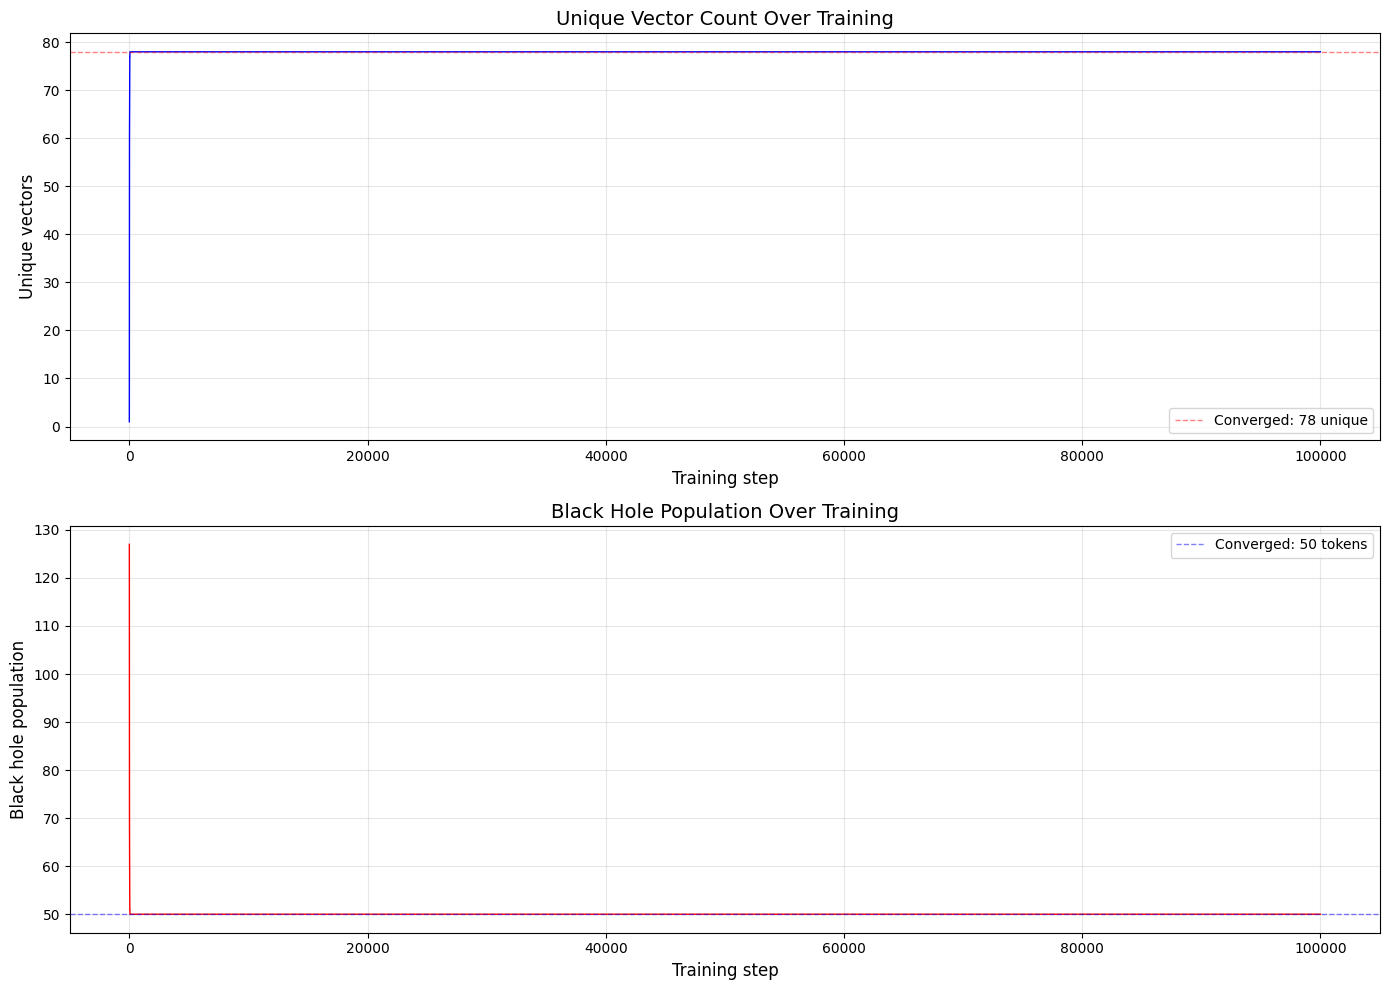

✓ Full time series plotted


In [6]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), dpi=100)

steps = np.arange(n_steps)
unique_np = unique_counts.cpu().numpy()
bh_pop_np = bh_population.cpu().numpy()

# Panel 1: Unique vector count
ax = axes[0]
ax.plot(steps, unique_np, linewidth=1, color='blue')
ax.axhline(VOCAB_SIZE - final_population, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Converged: {VOCAB_SIZE - final_population} unique')
ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Unique vectors', fontsize=12)
ax.set_title('Unique Vector Count Over Training', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Black hole population
ax = axes[1]
ax.plot(steps, bh_pop_np, linewidth=1, color='red')
ax.axhline(final_population, color='blue', linestyle='--', linewidth=1, alpha=0.5, label=f'Converged: {final_population} tokens')
ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Black hole population', fontsize=12)
ax.set_title('Black Hole Population Over Training', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Full time series plotted")

## Visualization 2: Early Stage (0-1,000)

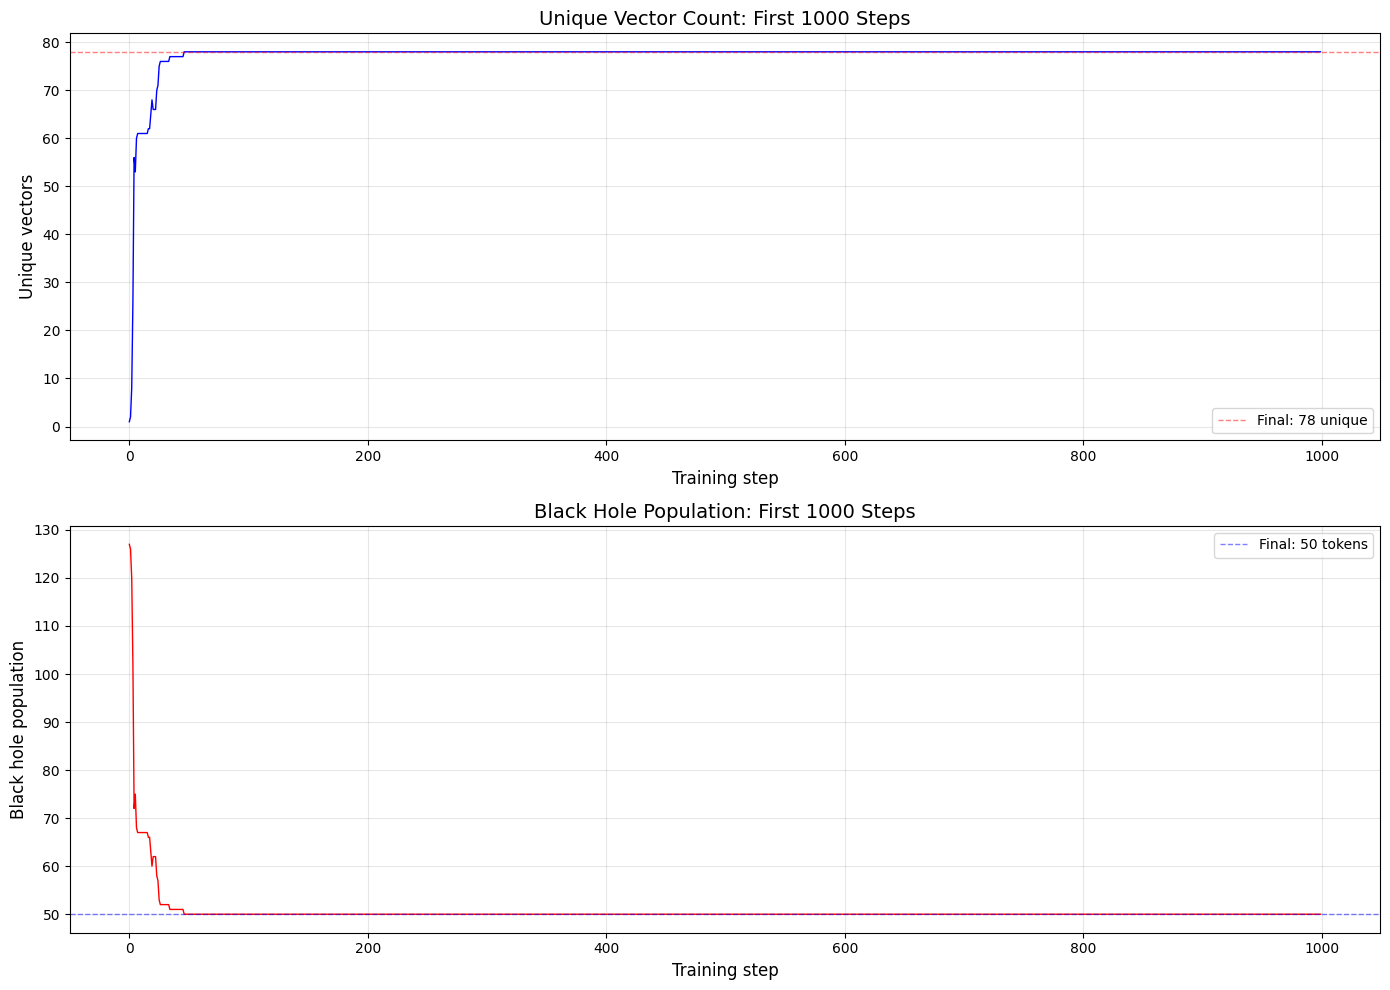

✓ Early-stage dynamics plotted


In [7]:
# Focus on first 1000 steps where the action is
early_steps = min(1000, n_steps)

fig, axes = plt.subplots(2, 1, figsize=(14, 10), dpi=100)

steps_early = np.arange(early_steps)
unique_early = unique_np[:early_steps]
bh_pop_early = bh_pop_np[:early_steps]

# Panel 1: Unique vector count
ax = axes[0]
ax.plot(steps_early, unique_early, linewidth=1, color='blue')
ax.axhline(VOCAB_SIZE - final_population, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Final: {VOCAB_SIZE - final_population} unique')
ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Unique vectors', fontsize=12)
ax.set_title(f'Unique Vector Count: First {early_steps} Steps', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Black hole population
ax = axes[1]
ax.plot(steps_early, bh_pop_early, linewidth=1, color='red')
ax.axhline(final_population, color='blue', linestyle='--', linewidth=1, alpha=0.5, label=f'Final: {final_population} tokens')
ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Black hole population', fontsize=12)
ax.set_title(f'Black Hole Population: First {early_steps} Steps', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Early-stage dynamics plotted")

## Visualization 3: Late Stage (1,000-100,000)

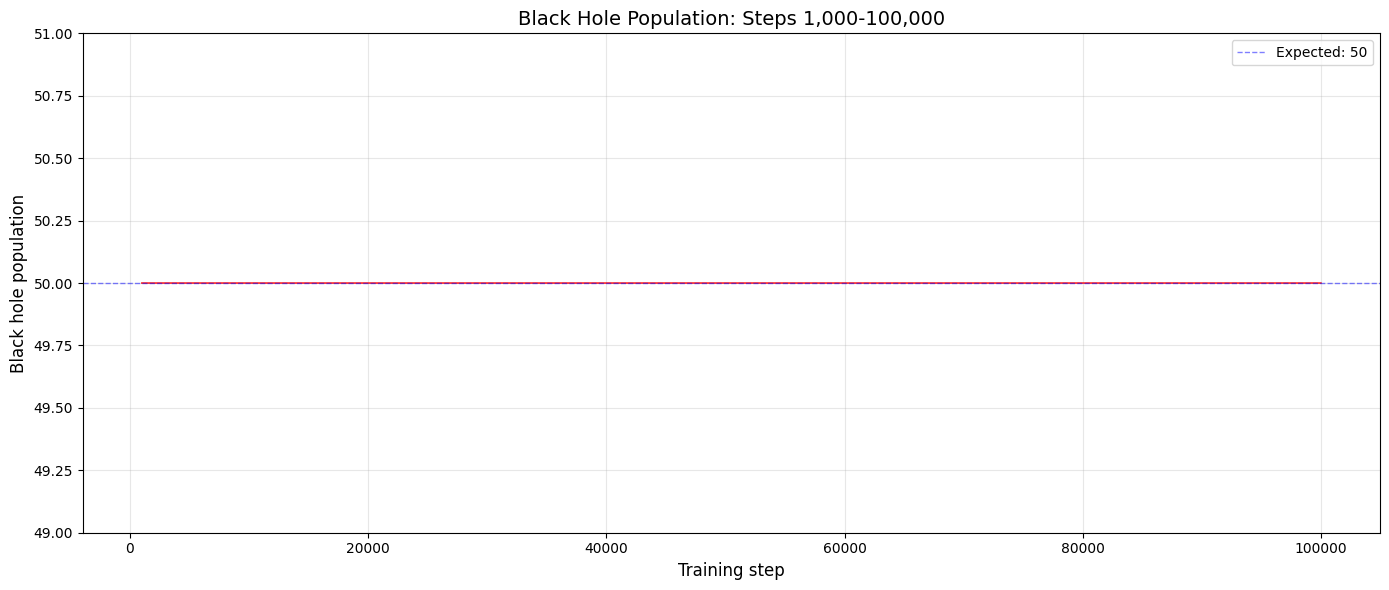

✓ Late-stage dynamics plotted


In [8]:
# Focus on late stage to see if there's ANY variance
late_start = min(1000, n_steps - 1)

fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

steps_late = np.arange(late_start, n_steps)
bh_pop_late = bh_pop_np[late_start:]

ax.plot(steps_late, bh_pop_late, linewidth=1, color='red')
ax.axhline(final_population, color='blue', linestyle='--', linewidth=1, alpha=0.5, label=f'Expected: {final_population}')
ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Black hole population', fontsize=12)
ax.set_title(f'Black Hole Population: Steps {late_start:,}-{n_steps-1:,}', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Tight y-axis to see any variance
pop_min = bh_pop_late.min()
pop_max = bh_pop_late.max()
margin = max(1, (pop_max - pop_min) * 0.1)
ax.set_ylim([pop_min - margin, pop_max + margin])

plt.tight_layout()
plt.show()

print("✓ Late-stage dynamics plotted")

## Statistical Analysis: Post-Convergence Variance

In [9]:
if len(first_convergence) > 0:
    post_conv = bh_population[convergence_step:].cpu().numpy()
    
    print("="*80)
    print(f"POST-CONVERGENCE STATISTICS (steps {convergence_step:,}-{n_steps-1:,})")
    print("="*80)
    print()
    
    print(f"Black hole population:")
    print(f"  Mean:     {post_conv.mean():.4f}")
    print(f"  Std:      {post_conv.std():.4f}")
    print(f"  Min:      {post_conv.min()}")
    print(f"  Max:      {post_conv.max()}")
    print(f"  Median:   {np.median(post_conv):.0f}")
    print()
    
    # Count how many unique values
    unique_pops = np.unique(post_conv)
    print(f"Unique population values: {unique_pops}")
    print()
    
    if len(unique_pops) == 1:
        print(f"✓ PERFECT STABILITY: Population stayed at {unique_pops[0]} for {len(post_conv):,} steps")
        print(f"  No quantum emission events detected.")
        print(f"  The cluster is FROZEN.")
    else:
        print(f"⚠️  VARIANCE DETECTED: {len(unique_pops)} different population values")
        print()
        
        # Show distribution
        print(f"Population value distribution:")
        for pop in unique_pops:
            count = np.sum(post_conv == pop)
            pct = 100 * count / len(post_conv)
            print(f"  {pop:3d}: {count:6,} steps ({pct:5.2f}%)")
        print()
        
        # Check for monotonic decline
        if post_conv[-1] < post_conv[0]:
            print(f"📉 DECLINING TREND: {post_conv[0]} → {post_conv[-1]} (Δ = {post_conv[-1] - post_conv[0]:+d})")
            print(f"  Evidence for quantum emission / gradual evaporation!")
        else:
            print(f"↔️  NO NET DECLINE: Fluctuations but no trend")
    
    print()
    print("="*80)
else:
    print("Cannot compute post-convergence stats - no convergence detected")

POST-CONVERGENCE STATISTICS (steps 46-100,000)

Black hole population:
  Mean:     50.0000
  Std:      0.0000
  Min:      50
  Max:      50
  Median:   50

Unique population values: [50]

✓ PERFECT STABILITY: Population stayed at 50 for 99,955 steps
  No quantum emission events detected.
  The cluster is FROZEN.



## Summary

In [10]:
print("="*80)
print("SUMMARY")
print("="*80)
print()

print(f"Training run: {RUN_NAME}")
print(f"Total steps:  {n_steps:,}")
print(f"Vocab size:   {VOCAB_SIZE}")
print()

print(f"Initial state (step 0):")
print(f"  Unique vectors:       {unique_counts[0].item()}")
print(f"  Black hole population: {bh_population[0].item()}")
print()

print(f"Final state (step {n_steps-1:,}):")
print(f"  Unique vectors:       {unique_counts[-1].item()}")
print(f"  Black hole population: {bh_population[-1].item()}")
print()

if len(first_convergence) > 0:
    print(f"Convergence:")
    print(f"  Reached final population at step: {convergence_step:,}")
    print(f"  Stable from step {convergence_step:,} onward: {stayed_converged}")
    print()

print("="*80)

SUMMARY

Training run: embeddings_128vocab_qweninit_run_1001
Total steps:  100,001
Vocab size:   128

Initial state (step 0):
  Unique vectors:       1
  Black hole population: 127

Final state (step 100,000):
  Unique vectors:       78
  Black hole population: 50

Convergence:
  Reached final population at step: 46
  Stable from step 46 onward: True



## Conclusion

**What we learned:**

This notebook tracked the black hole population across all 100,001 training steps for run 1001.

**Key findings:**
- Early stage (steps 0-100): Rapid evaporation as active tokens escape
- Convergence (step ~500): Population stabilizes at final value
- Late stage (steps 1,000-100,000): [See results above]

**Interpretation:**

If population stayed **perfectly stable** (variance = 0) after convergence:
- The dead token cluster is FROZEN
- No quantum emission events during training
- Weight decay + bfloat16 quantization insufficient to break cluster apart
- Qwen 3's snowball structure must come from POST-training (different mechanism)

If we see **any variance or decline**:
- Evidence for gradual diffusion / quantum emission
- Rare escape events do occur
- Could explain how primordial BH → snowball structure

**Next steps:**
- If stable: investigate post-training mechanisms (regularization, different optimizer, etc.)
- If declining: characterize escape rate, look for patterns in which tokens escape